In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка результатов

## **Изучение полученных результатов из УМ**

In [23]:
def get_result(config:str,
               way_type:str,
               fault:str,
               speed:int,
               profile:str = "gost") ->pd.DataFrame:
    """
    Получение результатов расчетов по ключевым словам
    1. `config` принимает два вида строк `empty` и `loaded`
    2. `way_type` принимает три вида строк `straight`, `curve_350` и `curve_650`
    3. `fault` принимает три вида строк `normal`, `polzun15`, `ellips10`
    4. `speed` от 10 до 60 км/ч
    5. `profile` есть профили `gost`, `newwagonw`, `greb_26`, `greb_30`, `greb_28`
    """
    dictionary = {"curve_350":{20:55,
                               30:39,
                               40:28,
                               50:24,
                               60:19},
                }
    if config == "empty":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\empty"
    
    elif config == "loaded":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\loaded"
    
    name = "\\"+config+"_"+way_type+"_"+fault+"_"+str(speed)+"_"+profile+".csv"

    l_name = len(name)

    FULL_PATH = PATH+name

    file = pd.read_csv(FULL_PATH,encoding='latin-1')

    COL_NAMES = ["time_step",name[1:l_name-4]]

    file.columns = COL_NAMES

    file = file.set_index("time_step")

    if config == "curve_350":
        file = file[file.index<dictionary["curve_350"][speed]]

    
    return file


In [24]:
def get_profile_results(config:str,
                        way_type:str,
                        fault:str,
                        speed:int):
    """Результаты расчета по всем видам профилей"""
    file1 = get_result(config, way_type,fault,speed)
    file2 = get_result(config, way_type,fault,speed, "greb_26")
    file3 = get_result(config, way_type,fault,speed, "greb_28")
    file4 = get_result(config, way_type,fault,speed, "greb_30")
    file5 = get_result(config, way_type,fault,speed, "newwagonw")

    return file1,file2,file3,file4,file5

In [25]:
def plot_profile_results(config:str,way_type:str,fault:str,speed:int):
    """Создание графика сравнения результатов с разным профилем колес"""
    d={"loaded":"Груженый",
       "empty":"Порожний",
       "straight":"прямая",
       "curve_350":"кривая 350 м",
       "curve_650":"кривая 650 м",
       "normal":"без неисправностей",
       "polzun15":"ползун",
       "ellips10":"неравномерный прокат"}
    
   #  sns.set (rc={' axes.facecolor':'#C0C0C0', 'figure.facecolor':'#FFFFF0 '})
    
    files = get_profile_results(config, way_type,fault,speed)
    FILE = pd.concat(files,axis=1)
    FILE.columns = ["gost","greb_26","greb_28","greb_30","newwagonw"]

    plt.figure(figsize=(12,8))
    plt.grid(True)
    sns.lineplot(FILE)
    plt.title(f"{d[config]} вагон, {d[way_type]}, {d[fault]} скорость {speed} км/ч ")
    plt.xlabel("Время, с")
    plt.ylabel("Вертикальная сила, Н")
    plt.show()
    



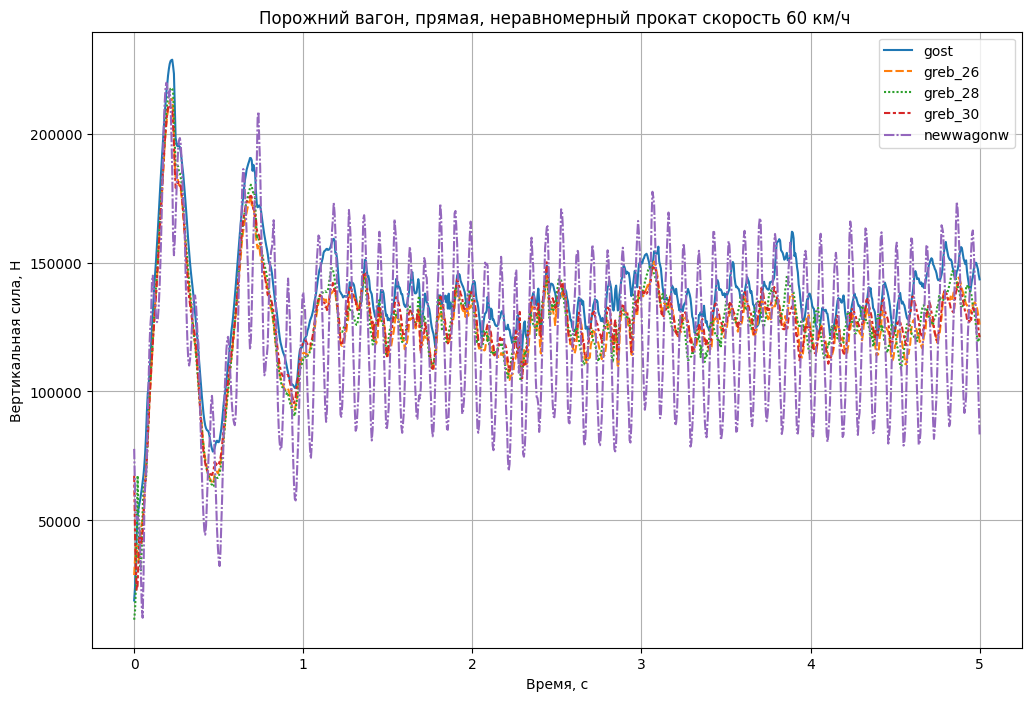

In [26]:
plot_profile_results("empty","straight","ellips10",60)

In [27]:
def get_speed_results(config:str,
                      way_type:str,
                      fault:str,
                      profile:str = "gost") -> list[pd.DataFrame]:
    """Получение расчета сразу по всем скоростям"""
    speed = [i for i in range(10,130,10)]

    results = []

    for v in speed:
        file = get_result(config,way_type,fault,profile=profile,speed=v)
        results.append(file)
    
    return results

In [28]:
wagon_cfg = ["empty","loaded"]
way_cfg = ["straight","curve_350","curve_650"]

d = {}

for wagon in wagon_cfg:
    d[wagon] = {}
    for way in way_cfg:
        d[wagon][way] = 0

print(d)

{'empty': {'straight': 0, 'curve_350': 0, 'curve_650': 0}, 'loaded': {'straight': 0, 'curve_350': 0, 'curve_650': 0}}


In [29]:
from IPython.display import clear_output

wagon_cfg = ["empty","loaded"]
way_cfg = ["straight","curve_350","curve_650"]
wheel_cfg = ["gost", "greb_26","greb_28","greb_30","newwagonw"]
fault_cfg = ["normal","polzun15","ellips10"]

def get_full_calculations(wagon_cfg:list,
                          way_cfg:list,
                          wheel_cfg:list,
                          fault_cfg:list) -> dict:
    """Получение словаря со всеми расчетами"""
    gen_dict = {}
    

    for wagon in wagon_cfg:
        gen_dict[wagon] = {}
        for way in way_cfg:
            gen_dict[wagon][way] = {}
            for fault in fault_cfg:   
                gen_dict[wagon][way][fault] = {}
                for wheel in wheel_cfg:
                    clear_output(True)
                    print(f"{wagon}\n{way}\n{fault}\n{wheel}\n------")
                    gen_dict[wagon][way][fault][wheel] = get_speed_results(wagon,way,fault,wheel)
    
    return gen_dict

In [30]:
ALL_CALCULATIONS = get_full_calculations(wagon_cfg,way_cfg,wheel_cfg,fault_cfg)

loaded
curve_650
ellips10
newwagonw
------


## **Подготовка инфы для разделения на кастомные фолды**

Так как колесо по ГОСТ имеет радиус 475 мм, то полный оборот колеса fold = 2*pi*475

Тогда время прохождения полного оборота колеса будет равно t = fold/v 

In [31]:
def time_split(v:int) -> int:
    """Определение временного промежутка полного оборота колеса
    1. v - скорость движения поезда, км/ч
    """
    speed = v/3.6
    lenght = 2*np.pi*0.475
    t = lenght/speed
    return t

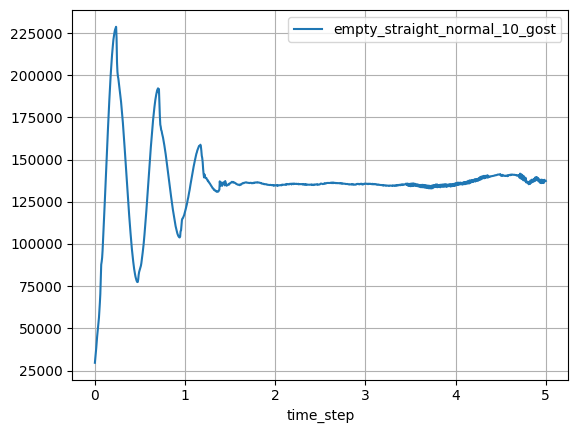

In [32]:
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS["empty"]["straight"]["normal"]["gost"][0])
plt.show()

In [33]:
def get_time_splits(data:pd.DataFrame) -> list:
    """Возвращает индексы по которым нужно производить обрез
    Индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = []

    start_point = 1.4

    time_max_point = data.index.max()               # Максимальное время

    if data.columns[0].split("_")[1] == "straight":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[3])) # 1.007 сек

    elif data.columns[0].split("_")[1] == "curve":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[4])) # 1.007 сек
        
    num_folds = (time_max_point-1)//wheel_rotate_num    # Сколько всего фолдов получится сделать

    res.append(start_point)

    for _ in range(int(num_folds)):
        start_point+= wheel_rotate_num
        res.append(start_point)

    return res

In [34]:
def time_indexes(frames:list[pd.DataFrame]) -> dict:
    """Возвращает словарь индексов по которым нужно производить обрез, где
    индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = {}

    for n in range(len(frames)):
        str = frames[n].columns[0].split("_")
        for s in str:
            if s.isdigit():
                if int(s) != 350 and int(s) != 650:
                    name = s

                    res[name] = get_time_splits(frames[n])
    
    return res

In [35]:
def get_all_time_indexes(calculations:dict[dict[dict[dict[list[pd.DataFrame]]]]]) -> dict:
    """Получение всех индексов времени по которым надо делить расчеты в виде словаря"""

    wagon_cfg = calculations.keys()
    way_cfg = calculations["empty"].keys()
    fault_cfg = calculations["empty"]["straight"].keys()
    wheel_cfg = calculations["empty"]["straight"]["normal"].keys()


    gen_dict = {}
    

    for wagon in wagon_cfg:
        gen_dict[wagon] = {}

        for way in way_cfg:
            gen_dict[wagon][way] = {}

            for fault in fault_cfg:   
                gen_dict[wagon][way][fault] = {}
                
                for wheel in wheel_cfg:
                    clear_output(True)
                    print(f"{wagon}\n{way}\n{fault}\n{wheel}\n------")
                    gen_dict[wagon][way][fault][wheel] = time_indexes(calculations[wagon][way][fault][wheel])
    
    return gen_dict

ALL_TIME_INDEXES = get_all_time_indexes(ALL_CALCULATIONS)

loaded
curve_650
ellips10
newwagonw
------


In [36]:
def get_splitted_dataframe(data:pd.DataFrame,indexes:list) -> pd.DataFrame:
    """Разделение одного результата расчета на несколько других по полному обороту колеса
    1. `data` - датафрейм с расчетом
    2. `indexes` - индексы по которым нужно делить расчет"""
    
    zeros = np.zeros((214,1))
    common_df = pd.DataFrame(zeros)

    for i in range(len(indexes)):
        if i < len(indexes) - 1:
            seq = data[(data.index>=indexes[i]) & (data.index<=indexes[i+1])]  # срез по точкам
        else:
            seq = data[data.index>indexes[i]]
        common_df = pd.concat([common_df,seq], axis=1)
    
    df = common_df.drop(0, axis=1)
    num_cols = len(df.columns)

    df.columns = [[data.columns[0] for i in range(num_cols)],[i for i in range(num_cols)]]
    
    return df       

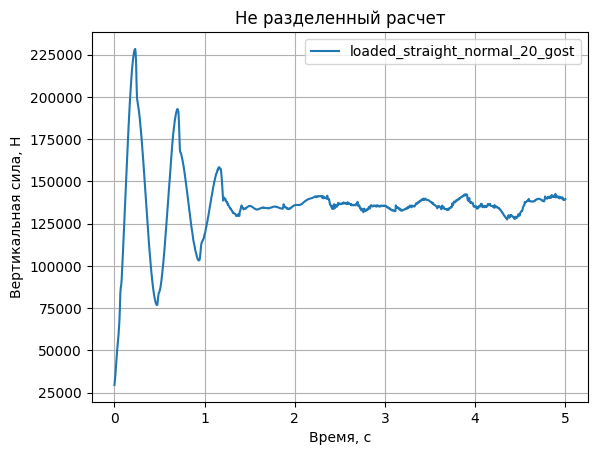

In [37]:
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS["loaded"]["straight"]["normal"]["gost"][1])
plt.title("Не разделенный расчет")
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.show()

**Пример разделения расчета на несколько мелких по обороту колеса**

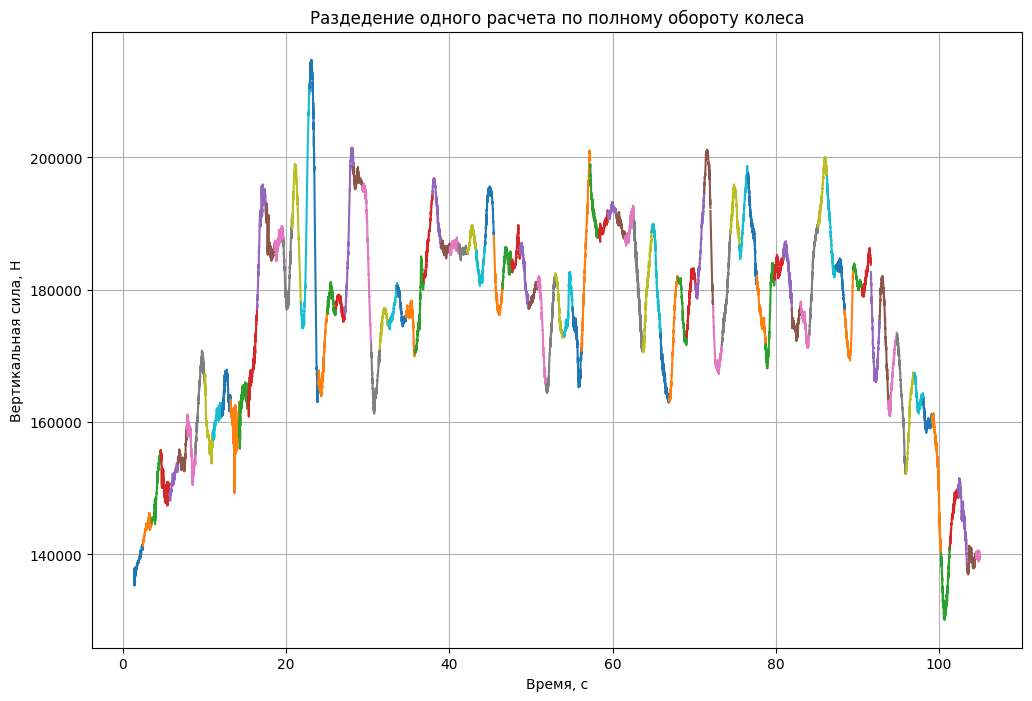

In [38]:
devided_result = get_splitted_dataframe(ALL_CALCULATIONS["loaded"]["curve_350"]["normal"]["gost"][0],
                                       ALL_TIME_INDEXES["loaded"]["curve_350"]["normal"]["gost"]["10"])

devided_result_ = get_splitted_dataframe(ALL_CALCULATIONS["loaded"]["curve_650"]["normal"]["gost"][0],
                                       ALL_TIME_INDEXES["loaded"]["curve_650"]["normal"]["gost"]["10"])

plt.figure().set_size_inches(12,8)
plt.grid(True)
plt.plot(devided_result)
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.title("Раздедение одного расчета по полному обороту колеса")
plt.show()

In [39]:
from scipy.stats import skew, kurtosis

def get_skew_kurt(data:pd.DataFrame) -> pd.DataFrame:
    """Получение дополнительных фичей для расчетов"""
    
    cols = data.columns

    skews = []
    kurtosises = []

    for i in cols:
        skew_ = skew(data[i].dropna().to_numpy())
        kurt_ = kurtosis(data[i].dropna().to_numpy())
        skews.append(skew_)
        kurtosises.append(kurt_)
    
    return pd.DataFrame({"skew":skews,"kurt":kurtosises}, index=cols).T

In [40]:
def get_description(data:pd.DataFrame) -> pd.DataFrame:
    """Получаем описанный фрейм и к нему добавляем доп фичи"""
    
    summ = data.sum()
    variance = data.var()
    skew_kurt = get_skew_kurt(data)
    desc = data.describe()

    summ_var = pd.concat([variance,summ],axis=1).T
    summ_var.index = ["var","sum"]
   
    df = pd.concat([desc,summ_var,skew_kurt], axis=0)
    return df

In [41]:
from IPython.display import clear_output

def make_frame_from_splits(calculations:dict,time_indexes:dict) -> pd.DataFrame:
    """Объединение всех разделенных расчетов на фолды и создание фичей"""
    
    wagon_cfg = calculations.keys()
    way_cfg = calculations["empty"].keys()
    fault_cfg = calculations["empty"]["straight"].keys()
    wheel_cfg = calculations["empty"]["straight"]["normal"].keys()
    speed_cfg = time_indexes["empty"]["straight"]["normal"]["gost"].keys()
    lenght = len(calculations["empty"]["straight"]["normal"]["gost"])
    
    zeros = np.zeros((1,12))
    common_df = pd.DataFrame(zeros)

    n = 0

    for wagon in wagon_cfg:
        for way in way_cfg:
            for fault in fault_cfg:
                for wheel in wheel_cfg:
                    for l,speed in zip(range(lenght),speed_cfg):
                        
                        splitted_df = get_splitted_dataframe(calculations[wagon][way][fault][wheel][l],
                                                            time_indexes[wagon][way][fault][wheel][speed])
                        
                        feats = get_description(splitted_df)

                        common_df = pd.concat([common_df,feats], axis=1)

                        clear_output(wait=True)
                        print(f"Сделано: {n}")
                        n+=1
                       
    
    df = common_df.drop(0, axis=0).drop(0,axis=1)

    return df                   

In [42]:
df = make_frame_from_splits(ALL_CALCULATIONS,ALL_TIME_INDEXES)

Сделано: 1079


In [44]:
unvalid_cols = [i for i in range(1,12)]

df_ = df.drop(unvalid_cols,axis=1)

df_

,"(empty_straight_normal_10_gost, 0)","(empty_straight_normal_10_gost, 1)","(empty_straight_normal_10_gost, 2)","(empty_straight_normal_10_gost, 3)","(empty_straight_normal_20_gost, 0)","(empty_straight_normal_20_gost, 1)","(empty_straight_normal_20_gost, 2)","(empty_straight_normal_20_gost, 3)","(empty_straight_normal_20_gost, 4)","(empty_straight_normal_20_gost, 5)",...,"(loaded_curve_650_ellips10_120_newwagonw, 314)","(loaded_curve_650_ellips10_120_newwagonw, 315)","(loaded_curve_650_ellips10_120_newwagonw, 316)","(loaded_curve_650_ellips10_120_newwagonw, 317)","(loaded_curve_650_ellips10_120_newwagonw, 318)","(loaded_curve_650_ellips10_120_newwagonw, 319)","(loaded_curve_650_ellips10_120_newwagonw, 320)","(loaded_curve_650_ellips10_120_newwagonw, 321)","(loaded_curve_650_ellips10_120_newwagonw, 322)","(loaded_curve_650_ellips10_120_newwagonw, 323)"
25%,1.351229e+05,1.349902e+05,1.347144e+05,1.370774e+05,1.342829e+05,1.355493e+05,1.350522e+05,1.339680e+05,1.351252e+05,1.297226e+05,...,7.405903e+04,7.476284e+04,9.798048e+04,9.301037e+04,7.832867e+04,1.252150e+05,NaN,NaN,NaN,NaN
50%,1.354354e+05,1.354424e+05,1.361668e+05,1.380941e+05,1.348991e+05,1.380250e+05,1.357869e+05,1.354548e+05,1.364791e+05,1.333217e+05,...,1.105228e+05,1.029365e+05,1.489228e+05,1.224951e+05,1.087829e+05,1.555731e+05,NaN,NaN,NaN,NaN
75%,1.360421e+05,1.357469e+05,1.399815e+05,1.404122e+05,1.353004e+05,1.404650e+05,1.363913e+05,1.374165e+05,1.391938e+05,1.356204e+05,...,1.468886e+05,1.482793e+05,1.795101e+05,1.560991e+05,1.530609e+05,1.727523e+05,NaN,NaN,NaN,NaN
count,2.150000e+02,2.150000e+02,2.150000e+02,7.600000e+01,1.080000e+02,1.070000e+02,1.080000e+02,1.070000e+02,1.080000e+02,1.070000e+02,...,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,8.000000e+00,0.0,0.0,0.0,0.0
kurt,-7.063126e-01,-7.844936e-01,-1.433097e+00,-1.239721e+00,5.854455e-01,-1.405319e+00,6.020329e-01,-1.078255e+00,-1.044524e+00,-1.341857e+00,...,-1.301578e+00,-1.234802e+00,-1.344774e+00,-1.238575e+00,-1.239922e+00,-9.040266e-01,NaN,NaN,NaN,NaN
max,1.372966e+05,1.363832e+05,1.414378e+05,1.417036e+05,1.374335e+05,1.424075e+05,1.400874e+05,1.400150e+05,1.414814e+05,1.386011e+05,...,1.790407e+05,1.869748e+05,1.956505e+05,1.929153e+05,1.926141e+05,1.854228e+05,NaN,NaN,NaN,NaN
mean,1.355502e+05,1.353842e+05,1.369463e+05,1.384862e+05,1.348355e+05,1.379723e+05,1.357001e+05,1.357407e+05,1.368428e+05,1.328480e+05,...,1.111981e+05,1.117752e+05,1.404998e+05,1.257702e+05,1.170943e+05,1.459366e+05,NaN,NaN,NaN,NaN
min,1.344390e+05,1.342251e+05,1.329122e+05,1.354013e+05,1.330368e+05,1.337697e+05,1.319713e+05,1.324931e+05,1.322868e+05,1.272572e+05,...,5.241802e+04,5.495045e+04,6.422191e+04,7.051571e+04,6.158125e+04,8.238745e+04,NaN,NaN,NaN,NaN
skew,4.328773e-01,-1.761325e-01,3.232902e-01,2.169695e-01,3.972545e-01,-1.115288e-02,-6.338588e-02,4.119405e-01,1.589060e-01,-2.662053e-02,...,1.643079e-01,3.257946e-01,-3.518851e-01,2.454447e-01,3.323945e-01,-6.280422e-01,NaN,NaN,NaN,NaN
std,5.773505e+02,5.137726e+02,2.652672e+03,1.766175e+03,7.378103e+02,2.593473e+03,1.390712e+03,2.132823e+03,2.383391e+03,3.460183e+03,...,4.167207e+04,4.400825e+04,4.627551e+04,4.040269e+04,4.407671e+04,3.663766e+04,NaN,NaN,NaN,NaN


In [45]:
new_cols = pd.MultiIndex.from_tuples(df_.columns)
df_.columns = new_cols

df_

empty_straight_normal_10_gost                                            \
                                0             1             2             3     
25%                    1.351229e+05  1.349902e+05  1.347144e+05  1.370774e+05   
50%                    1.354354e+05  1.354424e+05  1.361668e+05  1.380941e+05   
75%                    1.360421e+05  1.357469e+05  1.399815e+05  1.404122e+05   
count                  2.150000e+02  2.150000e+02  2.150000e+02  7.600000e+01   
kurt                  -7.063126e-01 -7.844936e-01 -1.433097e+00 -1.239721e+00   
max                    1.372966e+05  1.363832e+05  1.414378e+05  1.417036e+05   
mean                   1.355502e+05  1.353842e+05  1.369463e+05  1.384862e+05   
min                    1.344390e+05  1.342251e+05  1.329122e+05  1.354013e+05   
skew                   4.328773e-01 -1.761325e-01  3.232902e-01  2.169695e-01   
std                    5.773505e+02  5.137726e+02  2.652672e+03  1.766175e+03   
sum                    2.914329e+07  2.910759e+07  2.944346e+07  1.052495e+07   
var                    3.333336e+05  2.639623e+05  7.036669e+06  3.119375e+06   

      empty_straight_normal_20_gost                                            \
                                0             1             2             3     
25%                    1.342829e+05  1.355493e+05  1.350522e+05  1.339680e+05   
50%                    1.348991e+05  1.380250e+05  1.357869e+05  1.354548e+05   
75%                    1.353004e+05  1.404650e+05  1.363913e+05  1.374165e+05   
count                  1.080000e+02  1.070000e+02  1.080000e+02  1.070000e+02   
kurt                   5.854455e-01 -1.405319e+00  6.020329e-01 -1.078255e+00   
max                    1.374335e+05  1.424075e+05  1.400874e+05  1.400150e+05   
mean                   1.348355e+05  1.379723e+05  1.357001e+05  1.357407e+05   
min                    1.330368e+05  1.337697e+05  1.319713e+05  1.324931e+05   
skew                   3.972545e-01 -1.115288e-02 -6.338588e-02  4.119405e-01   
std                    7.378103e+02  2.593473e+03  1.390712e+03  2.132823e+03   
sum                    1.456223e+07  1.476303e+07  1.465561e+07  1.452426e+07   
var                    5.443641e+05  6.726103e+06  1.934081e+06  4.548933e+06   

                                   ...  \
                4             5    ...   
25%    1.351252e+05  1.297226e+05  ...   
50%    1.364791e+05  1.333217e+05  ...   
75%    1.391938e+05  1.356204e+05  ...   
count  1.080000e+02  1.070000e+02  ...   
kurt  -1.044524e+00 -1.341857e+00  ...   
max    1.414814e+05  1.386011e+05  ...   
mean   1.368428e+05  1.328480e+05  ...   
min    1.322868e+05  1.272572e+05  ...   
skew   1.589060e-01 -2.662053e-02  ...   
std    2.383391e+03  3.460183e+03  ...   
sum    1.477902e+07  1.421474e+07  ...   
var    5.680554e+06  1.197287e+07  ...   

      loaded_curve_650_ellips10_120_newwagonw                              \
                                          314           315           316   
25%                              7.405903e+04  7.476284e+04  9.798048e+04   
50%                              1.105228e+05  1.029365e+05  1.489228e+05   
75%                              1.468886e+05  1.482793e+05  1.795101e+05   
count                            1.800000e+01  1.800000e+01  1.800000e+01   
kurt                            -1.301578e+00 -1.234802e+00 -1.344774e+00   
max                              1.790407e+05  1.869748e+05  1.956505e+05   
mean                             1.111981e+05  1.117752e+05  1.404998e+05   
min                              5.241802e+04  5.495045e+04  6.422191e+04   
skew                             1.643079e-01  3.257946e-01 -3.518851e-01   
std                              4.167207e+04  4.400825e+04  4.627551e+04   
sum                              2.001567e+06  2.011954e+06  2.528997e+06   
var                              1.736561e+09  1.936726e+09  2.141423e+09   

                                                                    

In [46]:
df_.T.to_parquet("data_187k_raw.parquet")

## **подгрузка сохраненных результатов**

In [47]:
# DF = df_
DF = pd.read_parquet("data_187k_raw.parquet")

In [48]:
DF.head()

25%        50%         75%  count  \
empty_straight_normal_10_gost 0  135122.8700  135435.41  136042.135  215.0   
                              1  134990.1600  135442.38  135746.890  215.0   
                              2  134714.4000  136166.78  139981.480  215.0   
                              3  137077.3900  138094.11  140412.155   76.0   
empty_straight_normal_20_gost 0  134282.8875  134899.11  135300.415  108.0   

                                     kurt        max           mean  \
empty_straight_normal_10_gost 0 -0.706313  137296.64  135550.166558   
                              1 -0.784494  136383.25  135384.156000   
                              2 -1.433097  141437.78  136946.328140   
                              3 -1.239721  141703.59  138486.160789   
empty_straight_normal_20_gost 0  0.585445  137433.47  134835.488981   

                                       min      skew          std  \
empty_straight_normal_10_gost 0  134438.97  0.432877   577.350503   
                              1  134225.06 -0.176132   513.772628   
                              2  132912.20  0.323290  2652.672021   
                              3  135401.31  0.216969  1766.175195   
empty_straight_normal_20_gost 0  133036.84  0.397254   737.810315   

                                         sum           var  
empty_straight_normal_10_gost 0  29143285.81  3.333336e+05  
                              1  29107593.54  2.639623e+05  
                              2  29443460.55  7.036669e+06  
                              3  10524948.22  3.119375e+06  
empty_straight_normal_20_gost 0  14562232.81  5.443641e+05

In [49]:
def delete_unvalid_cols(data:pd.DataFrame) -> pd.DataFrame:
    """Удаление неликвидных колонок"""
    data_copy = data.T.copy()
    unvalid_cols = []

    for i in data_copy.columns:
        if data_copy[i].nunique() < 3:
            unvalid_cols.append(i)
    
    df = data_copy.drop(unvalid_cols, axis=1)

    return df.T


df = delete_unvalid_cols(DF)

df.head(15)

25%         50%          75%  count  \
empty_straight_normal_10_gost 0  135122.8700  135435.410  136042.1350  215.0   
                              1  134990.1600  135442.380  135746.8900  215.0   
                              2  134714.4000  136166.780  139981.4800  215.0   
                              3  137077.3900  138094.110  140412.1550   76.0   
empty_straight_normal_20_gost 0  134282.8875  134899.110  135300.4150  108.0   
                              1  135549.2600  138025.000  140465.0400  107.0   
                              2  135052.1825  135786.880  136391.3025  108.0   
                              3  133968.0450  135454.780  137416.4800  107.0   
                              4  135125.2000  136479.150  139193.8150  108.0   
                              5  129722.6450  133321.690  135620.4200  107.0   
                              6  138856.2325  139281.960  140310.2875   76.0   
empty_straight_normal_30_gost 0  135756.0700  138022.785  140731.4750   72.0   
                              1  134096.5050  134831.725  135766.8025   72.0   
                              2  134222.0050  135413.560  136828.5650   71.0   
                              3  134495.9325  137956.565  139700.8375   72.0   

                                     kurt        max           mean  \
empty_straight_normal_10_gost 0 -0.706313  137296.64  135550.166558   
                              1 -0.784494  136383.25  135384.156000   
                              2 -1.433097  141437.78  136946.328140   
                              3 -1.239721  141703.59  138486.160789   
empty_straight_normal_20_gost 0  0.585445  137433.47  134835.488981   
                              1 -1.405319  142407.47  137972.254673   
                              2  0.602033  140087.44  135700.088241   
                              3 -1.078255  140014.97  135740.734299   
                              4 -1.044524  141481.42  136842.750370   
                              5 -1.341857  138601.13  132848.003364   
                              6 -0.464909  142125.39  139577.283421   
empty_straight_normal_30_gost 0 -1.303969  142080.17  138062.748056   
                              1  1.656483  139802.20  135038.370833   
                              2 -0.890656  138906.36  135594.644507   
                              3 -0.707688  143106.27  137167.224444   

                                       min      skew          std  \
empty_straight_normal_10_gost 0  134438.97  0.432877   577.350503   
                              1  134225.06 -0.176132   513.772628   
                              2  132912.20  0.323290  2652.672021   
                              3  135401.31  0.216969  1766.175195   
empty_straight_normal_20_gost 0  133036.84  0.397254   737.810315   
                              1  133769.72 -0.011153  2593.473185   
                              2  131971.31 -0.063386  1390.712455   
                              3  132493.09  0.411940  2132.822840   
                              4  132286.78  0.158906  2383.391225   
                              5  127257.25 -0.026621  3460.183292   
                              6  137238.03  0.393940  1160.354642   
empty_straight_normal_30_gost 0  132676.08 -0.018984  2714.158995   
                              1  132329.78  1.137511  1597.508504   
                              2  132616.38  0.385801  1543.549120   
                              3  128372.61 -0.416986  3663.115624   

                                         sum           var  
empty_straight_normal_10_gost 0  29143285.81  3.333336e+05  
                              1  29107593.54  2.639623e+05  
                              2  29443460.55  7.036669e+06  
                              3  10524948.22  3.119375e+06  
empty_straight_normal_20_gost 0  14562232.81  5.443641e+05  
                              1  14763031.25  6.726103e+06  
                              2  14655609.53  1.934081e+06  
                              

# Пайплайн для обучения первой модельки 

*Предварительные результаты*

In [50]:
def new_str(value:str):
    """Замена строки типа `loaded_curve_650_normal_30_greb_30` на `loaded_curve650_normal_30_greb_30`"""

    if "curve" in value and "greb" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

        greb = splitted[5]
        greb_mm = splitted[6]
        new_word_2 = greb+greb_mm
        value = value.replace(greb_mm,"")
        value = value.replace(greb+"_",new_word_2)

        speed = splitted[4]

        if greb_mm == "30" and speed == "30":
            value = value.split("_")
            
            if "" in value:
                value.remove("")
            value.insert(3,"30")
            # print(value)
            value = "_".join(value)

    
    elif "curve" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

    return value

new_str("loaded_curve_650_normal_30_greb_30")

'loaded_curve650_normal_30_greb30'

In [51]:
df = df.reset_index().drop(["level_1"], axis=1)
df.head(15)

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,135122.8700,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.97,0.432877,577.350503,29143285.81,3.333336e+05
1,empty_straight_normal_10_gost,134990.1600,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.06,-0.176132,513.772628,29107593.54,2.639623e+05
2,empty_straight_normal_10_gost,134714.4000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.20,0.323290,2652.672021,29443460.55,7.036669e+06
3,empty_straight_normal_10_gost,137077.3900,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.31,0.216969,1766.175195,10524948.22,3.119375e+06
4,empty_straight_normal_20_gost,134282.8875,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.84,0.397254,737.810315,14562232.81,5.443641e+05
5,empty_straight_normal_20_gost,135549.2600,138025.000,140465.0400,107.0,-1.405319,142407.47,137972.254673,133769.72,-0.011153,2593.473185,14763031.25,6.726103e+06
6,empty_straight_normal_20_gost,135052.1825,135786.880,136391.3025,108.0,0.602033,140087.44,135700.088241,131971.31,-0.063386,1390.712455,14655609.53,1.934081e+06
7,empty_straight_normal_20_gost,133968.0450,135454.780,137416.4800,107.0,-1.078255,140014.97,135740.734299,132493.09,0.411940,2132.822840,14524258.57,4.548933e+06
8,empty_straight_normal_20_gost,135125.2000,136479.150,139193.8150,108.0,-1.044524,141481.42,136842.750370,132286.78,0.158906,2383.391225,14779017.04,5.680554e+06
9,empty_straight_normal_20_gost,129722.6450,133321.690,135620.4200,107.0,-1.341857,138601.13,132848.003364,127257.25,-0.026621,3460.183292,14214736.36,1.197287e+07


In [52]:
df["level_0"] = df["level_0"].map(new_str)

In [53]:
df

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05
1,empty_straight_normal_10_gost,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05
2,empty_straight_normal_10_gost,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06
3,empty_straight_normal_10_gost,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06
4,empty_straight_normal_20_gost,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,loaded_curve650_ellips10_120_newwagonw,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,2.011954e+06,1.936726e+09
183708,loaded_curve650_ellips10_120_newwagonw,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,2.528997e+06,2.141423e+09
183709,loaded_curve650_ellips10_120_newwagonw,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,2.263864e+06,1.632377e+09
183710,loaded_curve650_ellips10_120_newwagonw,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,2.107697e+06,1.942756e+09


In [54]:
new_cols = [f"new_col_{i}" for i in range(6)]

df[new_cols] = df['level_0'].str.split("_", expand=True)

In [55]:
df

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,empty_straight_normal_10_gost,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost,None
1,empty_straight_normal_10_gost,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost,None
2,empty_straight_normal_10_gost,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost,None
3,empty_straight_normal_10_gost,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost,None
4,empty_straight_normal_20_gost,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,loaded_curve650_ellips10_120_newwagonw,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,2.011954e+06,1.936726e+09,loaded,curve650,ellips10,120,newwagonw,None
183708,loaded_curve650_ellips10_120_newwagonw,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,2.528997e+06,2.141423e+09,loaded,curve650,ellips10,120,newwagonw,None
183709,loaded_curve650_ellips10_120_newwagonw,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,2.263864e+06,1.632377e+09,loaded,curve650,ellips10,120,newwagonw,None
183710,loaded_curve650_ellips10_120_newwagonw,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,2.107697e+06,1.942756e+09,loaded,curve650,ellips10,120,newwagonw,None


In [56]:
df = df.drop("level_0", axis=1)
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost,None
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost,None
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost,None
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost,None
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,2.011954e+06,1.936726e+09,loaded,curve650,ellips10,120,newwagonw,None
183708,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,2.528997e+06,2.141423e+09,loaded,curve650,ellips10,120,newwagonw,None
183709,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,2.263864e+06,1.632377e+09,loaded,curve650,ellips10,120,newwagonw,None
183710,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,2.107697e+06,1.942756e+09,loaded,curve650,ellips10,120,newwagonw,None


In [57]:
df = df.drop("new_col_5", axis=1)
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,2.011954e+06,1.936726e+09,loaded,curve650,ellips10,120,newwagonw
183708,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,2.528997e+06,2.141423e+09,loaded,curve650,ellips10,120,newwagonw
183709,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,2.263864e+06,1.632377e+09,loaded,curve650,ellips10,120,newwagonw
183710,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,2.107697e+06,1.942756e+09,loaded,curve650,ellips10,120,newwagonw


In [58]:
df.columns[:12]

Index(['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew',
       'std', 'sum', 'var'],
      dtype='object')

In [59]:
columns = ['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew','std', 'sum', 'var'] + ["wagon_cfg","way_cfg","target","speed","profile"]

df.columns=columns

df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,wagon_cfg,way_cfg,target,speed,profile
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,2.011954e+06,1.936726e+09,loaded,curve650,ellips10,120,newwagonw
183708,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,2.528997e+06,2.141423e+09,loaded,curve650,ellips10,120,newwagonw
183709,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,2.263864e+06,1.632377e+09,loaded,curve650,ellips10,120,newwagonw
183710,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,2.107697e+06,1.942756e+09,loaded,curve650,ellips10,120,newwagonw


In [60]:
df = pd.get_dummies(df,columns=["wagon_cfg","way_cfg","profile"],drop_first=True)

In [61]:
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,...,target,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb26,profile_greb28,profile_greb30,profile_newwagonw
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,...,normal,10,0,0,1,0,0,0,0,0
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,...,normal,10,0,0,1,0,0,0,0,0
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,...,normal,10,0,0,1,0,0,0,0,0
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,...,normal,10,0,0,1,0,0,0,0,0
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,...,normal,20,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,...,ellips10,120,1,1,0,0,0,0,0,1
183708,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,...,ellips10,120,1,1,0,0,0,0,0,1
183709,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,...,ellips10,120,1,1,0,0,0,0,0,1
183710,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,...,ellips10,120,1,1,0,0,0,0,0,1


In [62]:
df["speed"] = df["speed"].astype(int)

In [63]:
def binarize_target(string:str):
    if string == "normal":
        return 0
    else:
        return 1

def encode_target(string:str):
    if string == "normal":
        return 0
    elif string == "polzun15":
        return 1
    elif string == "ellips10":
        return 2

In [64]:
df["target"] = df["target"].map(encode_target)

df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,...,target,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb26,profile_greb28,profile_greb30,profile_newwagonw
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,...,0,10,0,0,1,0,0,0,0,0
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,...,0,10,0,0,1,0,0,0,0,0
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,...,0,10,0,0,1,0,0,0,0,0
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,...,0,10,0,0,1,0,0,0,0,0
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,...,0,20,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183707,74762.83550,102936.450,148279.3475,18.0,-1.234802,186974.83,111775.196722,54950.449,0.325795,44008.248800,...,2,120,1,1,0,0,0,0,0,1
183708,97980.47525,148922.830,179510.1050,18.0,-1.344774,195650.48,140499.812222,64221.906,-0.351885,46275.514901,...,2,120,1,1,0,0,0,0,0,1
183709,93010.36550,122495.125,156099.1375,18.0,-1.238575,192915.28,125770.206222,70515.711,0.245445,40402.691309,...,2,120,1,1,0,0,0,0,0,1
183710,78328.67175,108782.925,153060.8550,18.0,-1.239922,192614.13,117094.297944,61581.254,0.332394,44076.710902,...,2,120,1,1,0,0,0,0,0,1


In [65]:
df.dtypes

25%                  float64
50%                  float64
75%                  float64
count                float64
kurt                 float64
max                  float64
mean                 float64
min                  float64
skew                 float64
std                  float64
sum                  float64
var                  float64
target                 int64
speed                  int32
wagon_cfg_loaded       uint8
way_cfg_curve650       uint8
way_cfg_straight       uint8
profile_greb           uint8
profile_greb26         uint8
profile_greb28         uint8
profile_greb30         uint8
profile_newwagonw      uint8
dtype: object

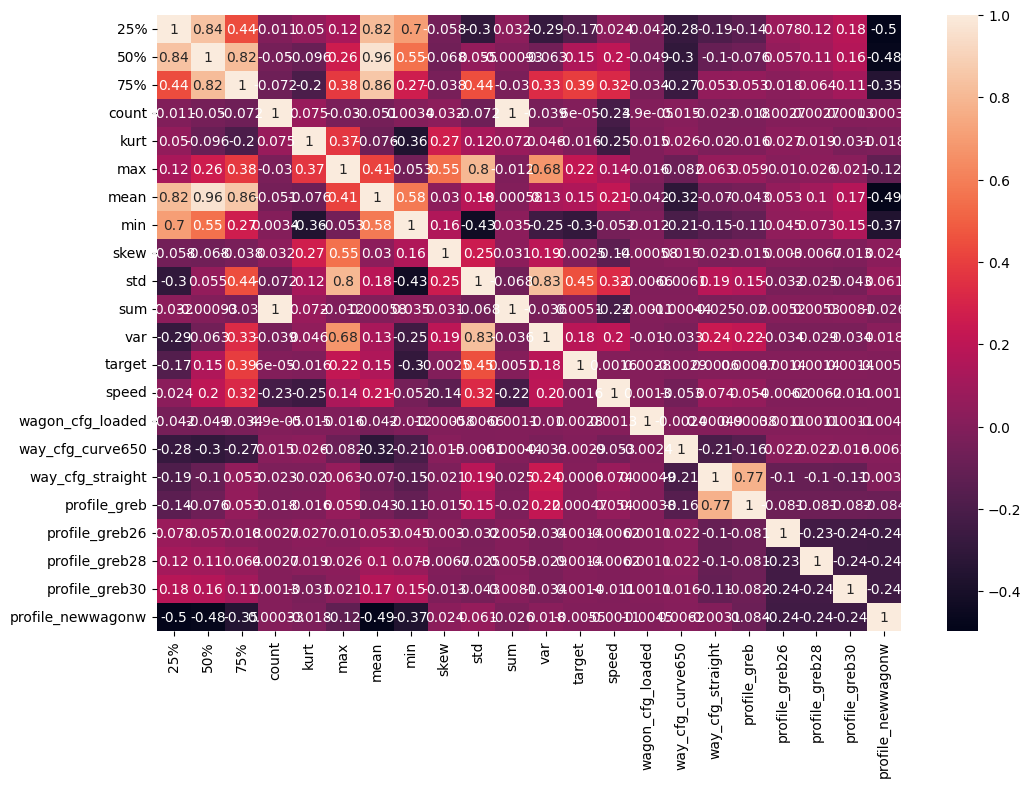

In [66]:
plt.figure().set_size_inches(12,8)
sns.heatmap(df.corr(),annot=True)
plt.show()

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

np.random.seed(32)

X = df.drop(["target","25%","50%","75%","count","sum"],axis=1)
y = df["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [85]:
xgb_pipe = Pipeline([("StandardScaler",StandardScaler()),("XGBClassifier",XGBClassifier(booster="gblinear"))])

xgb_pipe.fit(X_train,y_train)

print(classification_report(y_test,xgb_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     12360
           1       0.98      0.86      0.91     12162
           2       0.92      0.91      0.91     12221

    accuracy                           0.90     36743
   macro avg       0.90      0.90      0.90     36743
weighted avg       0.90      0.90      0.90     36743



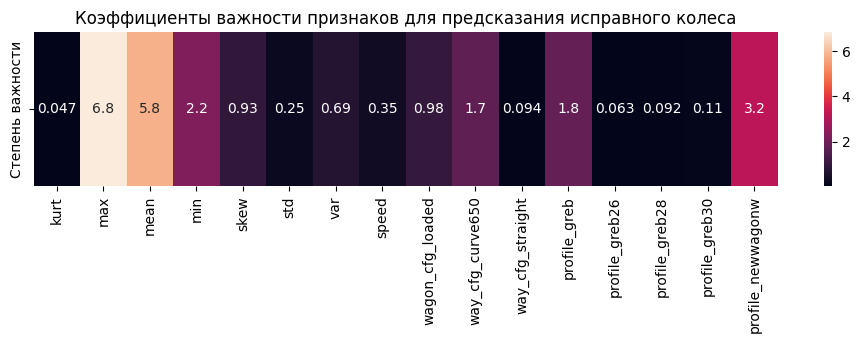

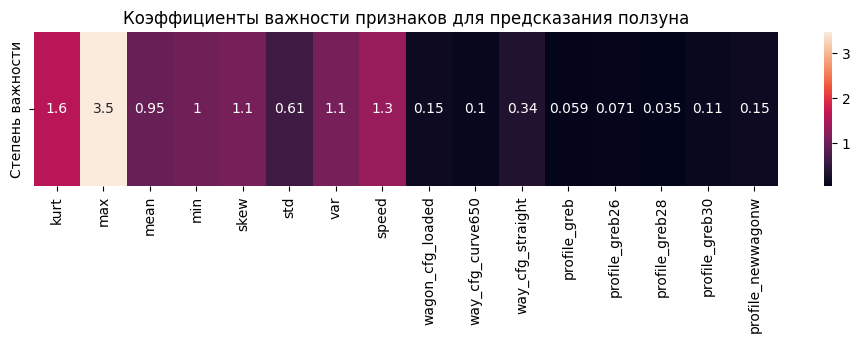

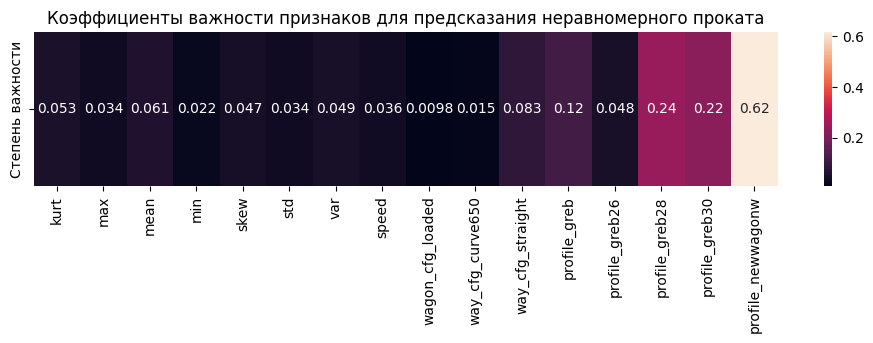

In [86]:
import catboost

def plot_feature_importance(estimator):
    
    if type(estimator[1]) != catboost.core.CatBoostClassifier:
        coefs = estimator[1].coef_

    elif type(estimator[1]) == catboost.core.CatBoostClassifier:
        coefs = estimator[1].feature_importances_
        
    if coefs.shape[0] == 3:
        d = {0:"исправного колеса",
             1:"ползуна",
             2:"неравномерного проката"}
        
    elif coefs.shape[0] == 2:
        d = {0:"исправного вагона",
             1:"неисправного вагона"}
    
    elif len(coefs.shape) == 1:
        d = {0:"модели Catboost"}
    
    if len(coefs) <= 3:
        for i in range(len(coefs)):
            df = pd.DataFrame(coefs[i]).T
            df.columns = estimator[:-1].get_feature_names_out()
            df.index = ["Степень важности"]
            plt.figure().set_size_inches(12,2)
            plt.title(f"Коэффициенты важности признаков для предсказания {d[i]}")
            sns.heatmap(abs(df), annot=True)
            plt.show()
        
    elif len(coefs.shape) == 1:
        df = pd.DataFrame(coefs).T
        df.columns = estimator[:-1].get_feature_names_out()
        df.index = ["Степень важности"]
        plt.figure().set_size_inches(12,2)
        plt.title(f"Коэффициенты важности признаков для предсказания неисправностей {d[0]}")
        sns.heatmap(abs(df), annot=True)
        plt.show()

    else:
        print(len(coefs))
        
plot_feature_importance(xgb_pipe)

In [87]:
from catboost import CatBoostClassifier

cat_pipe = Pipeline([("StandardScaler",StandardScaler()),("CatBoostClassifier",CatBoostClassifier())])

cat_pipe.fit(X_train,y_train)


Learning rate set to 0.102059
0:	learn: 0.9579140	total: 23.2ms	remaining: 23.1s
1:	learn: 0.8516690	total: 42.3ms	remaining: 21.1s
2:	learn: 0.7685229	total: 60.1ms	remaining: 20s
3:	learn: 0.7007656	total: 79.3ms	remaining: 19.7s
4:	learn: 0.6457722	total: 98.2ms	remaining: 19.5s
5:	learn: 0.5994071	total: 116ms	remaining: 19.2s
6:	learn: 0.5593439	total: 135ms	remaining: 19.1s
7:	learn: 0.5246264	total: 154ms	remaining: 19.1s
8:	learn: 0.4956977	total: 174ms	remaining: 19.2s
9:	learn: 0.4708603	total: 192ms	remaining: 19s
10:	learn: 0.4483543	total: 214ms	remaining: 19.2s
11:	learn: 0.4279504	total: 235ms	remaining: 19.4s
12:	learn: 0.4096473	total: 255ms	remaining: 19.3s
13:	learn: 0.3948307	total: 273ms	remaining: 19.2s
14:	learn: 0.3800026	total: 292ms	remaining: 19.2s
15:	learn: 0.3671974	total: 309ms	remaining: 19s
16:	learn: 0.3559834	total: 329ms	remaining: 19s
17:	learn: 0.3457303	total: 349ms	remaining: 19s
18:	learn: 0.3370915	total: 367ms	remaining: 18.9s
19:	learn: 0.328

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001499F456850>)])

In [71]:
print(classification_report(y_test,cat_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90     12360
           1       0.98      0.88      0.93     12162
           2       0.94      0.96      0.95     12221

    accuracy                           0.92     36743
   macro avg       0.93      0.92      0.92     36743
weighted avg       0.93      0.92      0.92     36743



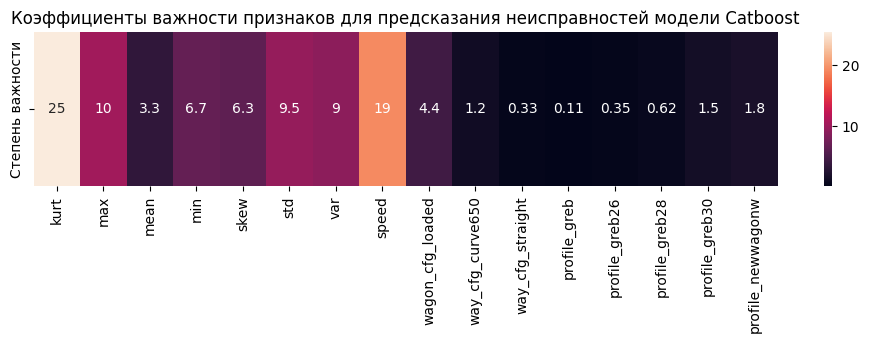

In [72]:
plot_feature_importance(cat_pipe)

In [73]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=cat_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=cat_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="Classifier")

display.plot()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=xgb_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=xgb_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="XGB Classifier")

display.plot()
plt.show()

**PCA TSNE**

In [86]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

X_embedded

array([[ -36.202747,   35.792503],
       [  17.998075,   87.26539 ],
       [   1.366305,  -38.49477 ],
       ...,
       [ -70.36562 ,  -38.976074],
       [ -52.219196, -109.89604 ],
       [  78.46959 ,  -87.85986 ]], dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf = XGBClassifier()


# Loading some example data

# print(X)
# print(y)

# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure().set_size_inches(12,8)

labels = ['Предсказания модели XGboost']
          

for clf, lab, grd in zip([clf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_embedded, y)
    
    # ax = plt.subplot(gs[grd[0], grd[1]])
    plt.plot(grd[0],grd[1])
    fig = plot_decision_regions(X=X_embedded, y=y.to_numpy(),
                                clf=clf, legend=1)
    plt.title(lab)

plt.show()

In [ ]:
X.head().to_excel("пример для презентации.xlsx")

In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score

def save_results(estimator,X_test,y_test):
    
    ave = "micro"
    y_pred = estimator.predict(X_test)
    presicion = precision_score(y_test,y_pred,average=ave)
    recall = recall_score(y_test,y_pred,average=ave)
    f1_ = f1_score(y_test,y_pred,average=ave)

    df = pd.read_csv("stat_results.csv")

    shape = X_test.shape[0]
    

    line = pd.DataFrame({"step1":[estimator.steps[0][0]],
                         "step2":[estimator.steps[1][0]],
                         "test_size":[shape],
                         "presicion":[presicion],
                         "recall":[recall],
                         "f1_score":[f1_]})
    
    updated_stats = pd.concat([df,line],axis=0).drop("Unnamed: 0",axis=1).to_csv("stat_results.csv")

    return updated_stats

In [107]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Normalizer

lgbm_pipe = Pipeline([("Normalizer",Normalizer()),("LGBMClassifier",LGBMClassifier())])

lgbm_pipe.fit(X_train,y_train)

print(classification_report(y_test,lgbm_pipe.predict(X_test)))

save_results(lgbm_pipe,X_test,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 146969, number of used features: 16
[LightGBM] [Info] Start training from score -1.095223
[LightGBM] [Info] Start training from score -1.099708
[LightGBM] [Info] Start training from score -1.100915
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     12360
           1       0.98      0.87      0.92     12162
           2       0.93      0.95      0.94     12221

    accuracy                           0.91     36743
   macro avg       0.92      0.91      0.91     36743
weighted avg       0.92      0.91      0.91     36743



In [92]:
save_results(cat_pipe,X_test,y_test)

save_results(xgb_pipe,X_test,y_test)

In [97]:
stats = pd.read_csv("stat_results.csv").drop(["Unnamed: 0"],axis=1)
stats


,step1,step2,presicion,recall,f1_score,test_size
0,StandardScaler,CatBoostClassifier,0.924394,0.924394,0.924394,36743.0
1,StandartScaler,LGBMClassifier,0.923577,0.923577,0.923577,36743.0
2,StandardScaler,XGBClassifier,0.895273,0.895273,0.895273,36743.0


In [108]:
def show_stat_results():
    data = pd.read_csv("stat_results.csv")
    columns = data.columns

    cols_to_drop = []

    if "Unnamed: 0" in columns:
        print("in")
        for c in columns:
            if "Unnamed" in c:
                cols_to_drop.append(c)
        # print(cols_to_drop)
        return data.drop(cols_to_drop,axis=1)
    
    elif "Unnamed: 0" not in columns:
        return data

show_stat_results()

in


,step1,step2,presicion,recall,f1_score,test_size
0,StandardScaler,CatBoostClassifier,0.924394,0.924394,0.924394,36743.0
1,StandartScaler,LGBMClassifier,0.923577,0.923577,0.923577,36743.0
2,StandardScaler,XGBClassifier,0.895273,0.895273,0.895273,36743.0
3,Normalizer,LGBMClassifier,0.913997,0.913997,0.913997,36743.0
